In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rseeds = [20090425, 19700903]

In [2]:
data_file = 'data/Tonsillectomy_KQ5_Bleeding_Data_07202016.xlsx'

raw_data = (pd.read_excel(data_file, 
              sheetname='Bleeding_Dexa vs Placebo_KQ5', 
              na_values=['null', 'ND']))
raw_data.shape

(48, 16)

In [3]:
raw_data.head()

,Citation,REFID,Number_ of_Arms,Rx_Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,OUTC_Main_ CATG,Outc_SUB_ CATG,New_Bleeding_specify,Outcome_timepoint,OUTCOME_SAMPLE_SIZE,Outcome_count,Outcome_%
0,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Primary bleeding,POD5,154,2,1.0
1,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G2:,placebo (saline),placebo,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Primary bleeding,POD5,151,2,1.0
2,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Undefined bleeding,POD5,154,15,9.7
3,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G2:,placebo (saline),placebo,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Undefined bleeding,POD5,151,11,7.3
4,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Revisit/Readmission-bleeding,POD5,154,3,1.9


In [4]:
raw_data.REFID.unique()

array([ 1039,  1085,  2213,  3031,  3213,  3498,  6452,  6586, 12791])

In [5]:
high_ROB = 6586, 12791

In [6]:
raw_data.New_Bleeding_specify.value_counts().shape

(5,)

In [7]:
raw_data.Intervention_category.value_counts()

perioperative steroid    27
placebo                  21
Name: Intervention_category, dtype: int64

In [19]:
from pymc3 import Model, sample, traceplot, forestplot, summary, waic
from pymc3 import Normal, Binomial, invlogit, HalfCauchy, Deterministic, exp

def create_model(_data, bleeding_specific=False):
    
    data = _data.copy()
    
    unique_studies = data.REFID.unique()
    n_studies = len(unique_studies)
    
    bleeding = data.New_Bleeding_specify.unique()
    n_bleeding = len(bleeding)
    
    data['study_id'] = data.REFID.replace(dict(zip(unique_studies, range(n_studies))))
    data['bleeding_type'] = (data.New_Bleeding_specify
                             .replace(dict(zip(bleeding, range(n_bleeding)))))
    
    data['treatment'] = (data.Intervention_category=='perioperative steroid').astype(int)
    
    b, t, i, n, y = data[['bleeding_type', 'treatment', 
                          'study_id', 'OUTCOME_SAMPLE_SIZE', 'Outcome_count']].T.values
    
    with Model() as model:

        # Study random effect
        σ = HalfCauchy('σ', 5)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies)
        
        # Bleeding type means
        μ = Normal('μ', 0, sd=100, shape=n_bleeding)

        if bleeding_specific:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100, shape=n_bleeding)

            θ = invlogit(μ[b] + δ[b]*t + ϵ[i])
        else:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100)

            θ = invlogit(μ[b] + δ*t + ϵ[i])
        
        data_likelhood = Binomial('data_likelihood', n=n, p=θ, observed=y)
        
        odds = Deterministic('odds', exp(δ))
        
    return model

### Pooled effect size, all studies

In [25]:
pooled_model = create_model(raw_data)

Applied log-transform to σ and added transformed σ_log_ to model.


In [26]:
with pooled_model:
    
    pooled_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 71.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12503fdd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1245ac668>]], dtype=object)

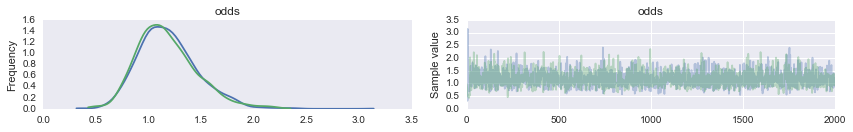

In [28]:
traceplot(pooled_trace, varnames=['odds'])

In [29]:
summary(pooled_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.181            0.285            0.006            [0.680, 1.755]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.721          0.982          1.150          1.343          1.820



In [30]:
waic(pooled_trace, model=pooled_model)

435.35957088771352

### Pooled effect size, exclude high ROB studies

In [9]:
low_rob_model = create_model(raw_data[~raw_data.REFID.isin(high_ROB)])

Applied log-transform to σ and added transformed σ_log_ to model.


In [10]:
with low_rob_model:
    
    low_rob_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 80.5 sec

In [11]:
summary(low_rob_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.228            0.304            0.006            [0.685, 1.840]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.731          1.015          1.196          1.410          1.901



In [20]:
waic(low_rob_trace, model=low_rob_model)

322.29973709316511

## Bleeding-specific effects, all studies

In [13]:
full_model = create_model(raw_data, bleeding_specific=True)

Applied log-transform to σ and added transformed σ_log_ to model.


In [14]:
with full_model:
    
    full_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 111.4 sec

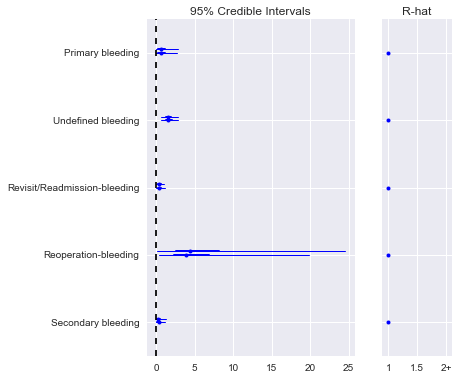

In [18]:
forestplot(full_trace, varnames=['odds'], ylabels=raw_data.New_Bleeding_specify.unique())

In [16]:
summary(full_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.971            1.293            0.035            [0.008, 2.819]
  1.667            0.591            0.009            [0.711, 2.905]
  0.474            0.322            0.006            [0.054, 1.081]
  7.349            13.011           0.521            [0.134, 21.827]
  0.458            0.487            0.009            [0.002, 1.309]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.066          0.313          0.606          1.183          3.761
  0.830          1.254          1.552          1.960          3.178
  0.108          0.254          0.399          0.600          1.319
  1.015          2.450          4.179          7.527          32.291
  0.038          0.172          0.324          0.575          1.707



In [21]:
waic(full_trace, model=full_model)

393.11841730449868

## Goodness of fit

For full model

In [58]:
from pymc3 import sample_ppc

full_ppc = sample_ppc(full_trace, model=full_model, samples=500)

In [59]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

sim_days = full_ppc['data_likelihood']
sim_days.shape

(500, 48)

In [64]:
(sim_days < raw_data.Outcome_count.values).mean(0)

array([ 0.564,  0.422,  0.604,  0.67 ,  0.522,  0.312,  0.258,  0.42 ,
        0.   ,  0.   ,  0.588,  0.   ,  0.   ,  0.924,  0.426,  0.022,
        0.972,  0.112,  0.726,  0.208,  0.876,  0.   ,  0.   ,  0.   ,
        0.   ,  0.43 ,  0.   ,  0.506,  0.   ,  0.848,  0.   ,  0.612,
        0.   ,  0.   ,  0.   ,  0.652,  0.   ,  0.78 ,  0.   ,  0.   ,
        0.832,  0.568,  0.   ,  0.   ,  0.   ,  0.876,  0.   ,  0.   ])

The fit of this model is very poor, as evidenced by the zeros.

## Mixture model

In [68]:
from pymc3 import Model, sample, traceplot, forestplot, summary, waic, DensityDist
from pymc3 import Normal, Binomial, invlogit, HalfCauchy, Deterministic, exp, Beta, log
import theano.tensor as tt

def create_zib_model(_data, bleeding_specific=False):
    
    data = _data.copy()
    
    unique_studies = data.REFID.unique()
    n_studies = len(unique_studies)
    
    bleeding = data.New_Bleeding_specify.unique()
    n_bleeding = len(bleeding)
    
    data['study_id'] = data.REFID.replace(dict(zip(unique_studies, range(n_studies))))
    data['bleeding_type'] = (data.New_Bleeding_specify
                             .replace(dict(zip(bleeding, range(n_bleeding)))))
    
    data['treatment'] = (data.Intervention_category=='perioperative steroid').astype(int)
    
    b, t, i, n, y = data[['bleeding_type', 'treatment', 
                          'study_id', 'OUTCOME_SAMPLE_SIZE', 'Outcome_count']].T.values
    
    with Model() as model:
        
        # Probability of no bleeding
        ψ = Beta('ψ', 1, 1)

        # Study random effect
        σ = HalfCauchy('σ', 5)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies)
        
        # Bleeding type means
        μ = Normal('μ', 0, sd=100, shape=n_bleeding)

        if bleeding_specific:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100, shape=n_bleeding)

            θ = invlogit(μ[b] + δ[b]*t + ϵ[i])
        else:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100)

            θ = invlogit(μ[b] + δ*t + ϵ[i])
            
        def zero_inflated_binomial(value):
            return tt.switch(value>0, log(ψ) + Binomial.dist(n=n, p=θ).logp(value),
                                    log((1-ψ)) * (1-θ)**n).sum()
        
        data_likelhood = DensityDist('data_likelihood', zero_inflated_binomial, observed=y)
        
        odds = Deterministic('odds', exp(δ))
        
    return model

In [69]:
full_zib_model = create_zib_model(raw_data, bleeding_specific=True)

Applied logodds-transform to ψ and added transformed ψ_logodds_ to model.
Applied log-transform to σ and added transformed σ_log_ to model.


In [71]:
with full_zib_model:
    
    full_zib_trace = sample(2000)

Assigned NUTS to ψ_logodds_
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 174.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ba16f60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132f11e80>]], dtype=object)

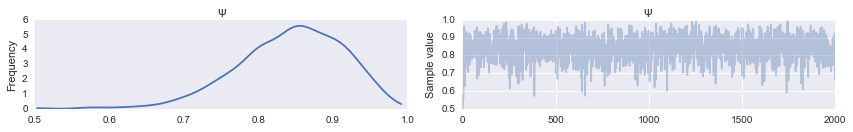

In [72]:
traceplot(full_zib_trace, varnames=['ψ'])

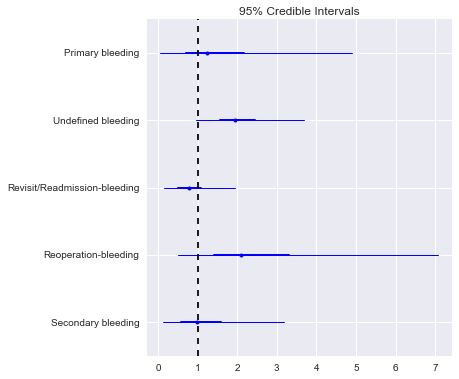

In [76]:
forestplot(full_zib_trace, varnames=['odds'], 
           ylabels=raw_data.New_Bleeding_specify.unique(), vline=1)